# Диахронические датасеты НКРЯ
### Выполнила Елизавета Клыкова, БКЛ-181

**Требования:**
* ✔ 2 - нереляционная БД
* ? 2 - красивая структура БД
* ✔ 2 - интерфейс позволяет класть, доставать, удалять данные (проводить операции CRUD -- Create, Read, Update, Delete)
* ✔ 2 - два действия помимо CRUD (сортировка, группировка, агрегация, ...)
* ✔ 2 - зависит от БД:
    * MongoDB, ElasticSearch -- работа с текстами или географией

**Причины выбора Mongo:**
- умеет работать с текстами
- популярна в продакшене
- простой интерфейс
- более гибкая, чем ElasticSearch
- ElasticSearch так и не заработал :(

## Импорты

In [1]:
# !pip install pymongo
# !pip install stanza

In [2]:
import pymongo

import pandas as pd
import numpy as np

import stanza

import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.auto import tqdm

## О датасете
[Диахронические датасеты НКРЯ](https://ruscorpora.ru/new/corpora-usage.html) доступны для использования в учебных и научных целях после подписания лицензионного соглашения. Это набор данных из трех частей, соответствующих трем периодам: досоветскому (1688-1916), советскому (1918-1990) и постсоветскому (1992-2016).

Получить доступ к датасетам вовремя не получилось, поэтому для заполнения базы будем использовать небольшую выборку примеров с глаголом "приехать".

In [3]:
df = pd.read_csv('ruscorpora_content.csv', sep=';')
df = df[['Author', 'Header', 'Sphere', 'Type', 'Topic', 'Medium', 'Full context']]
df.sample(5)

,Author,Header,Sphere,Type,Topic,Medium,Full context
420,Юрий Давыдов,Синие тюльпаны,художественная,роман,NaN,книга,"Пришлёт, я, не мешкая, приеду с оценочной коми..."
278,Андрей Волос,Недвижимость,художественная,роман,NaN,журнал,Ладно. Точно приедете? ― Да о чём речь! ― во...
597,Юрий Трифонов,Предварительные итоги,художественная,повесть,NaN,книга,"Нюра осталась одна одиннадцати лет, не понимал..."
243,NaN,"Мстислав Ростропович: «Это особое ощущение, ко...",публицистика | нехудожественная,интервью,искусство и культура,газета,"Сейчас, например, могу сказать, что приехал до..."
46,Сергей Козлов,Как Ёжик с Медвежонком спасли Волка,художественная,сказка,NaN,журнал,".. ""Хорошо ему, ― подумал Волк, ― уши у него н..."


Имитируя структуру диахронического датасета, разделим датафрейм на три части. Поскольку предложения в файле отсортированы от новых к старым, первую треть будем считать за постсоветский период, а последнюю -- за досоветский.

In [4]:
pre_soviet, soviet, post_soviet = np.array_split(df, 3)

In [5]:
pre_soviet['Period'] = 0
soviet['Period'] = 1
post_soviet['Period'] = 2

In [6]:
sent_df = pd.concat([pre_soviet, soviet, post_soviet], ignore_index=True)
sent_df.head()

,Author,Header,Sphere,Type,Topic,Medium,Full context,Period
0,коллективный,Форум: Были вы в стране преподаваемого языка?,электронная коммуникация | нехудожественная,форум,образование | путешествия,электронный текст,"[patrol, nick] И, естественно, приехав в Росс...",0
1,коллективный,Форум: Были вы в стране преподаваемого языка?,электронная коммуникация | нехудожественная,форум,образование | путешествия,электронный текст,"[Джула, nick] И где гарантия, что, приехав в ...",0
2,коллективный,Форум: комментарии к фильму «Все будет хорошо»,электронная коммуникация | нехудожественная,комментарии,"досуг, зрелища и развлечения | искусство и кул...",электронный текст,"[anutikmor, жен] !! Приехал к ним в гости милл...",0
3,коллективный,Форум: комментарии к фильму «Все будет хорошо»,электронная коммуникация | нехудожественная,комментарии,"досуг, зрелища и развлечения | искусство и кул...",электронный текст,"[anutikmor, жен] Приехал миллионер к своей пе...",0
4,коллективный,Форум: комментарии к фильму «Все будет хорошо»,электронная коммуникация | нехудожественная,комментарии,"досуг, зрелища и развлечения | искусство и кул...",электронный текст,[awesom13] Каждая семья здесь имеет свою исто...,0


## Работа с базой

### Подключение к базе

In [7]:
client = pymongo.MongoClient('localhost', 27017)
db = client['diachronic_datasets']
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'diachronic_datasets')

### Создание коллекций

Коллекция prefixes содержит поля:
* prefix_name -- собственно текст приставки
* senses -- список значений приставки

Значения приставок взяты из [онлайн-версии словаря Ожегова](http://www.slovorod.ru/dic-ozhegov/index.html).

In [8]:
prefixes = db.prefixes
sentences = db.sentences
lemmas = db.lemmas
tokens = db.tokens

In [9]:
prefixes.delete_many({})
sentences.delete_many({})
lemmas.delete_many({})
tokens.delete_many({})

#### Работа с приставками

In [10]:
class Prefix:

    def __init__(self, prefix_name, senses):
        self.prefix_name = prefix_name
        self.senses = senses

    def to_dict(self):
        return {'prefix_name': self.prefix_name,
                'senses': self.senses}

In [11]:
prefix_pri = Prefix('при',
                    ['доведения действия до конечной цели, напр. приехать, приблизиться, прибрести, приплестись;',
                     'добавления, сближения, скрепления чего-н. с чем-н., напр. приземлить, пристроить, приделать, припечатать, приложить, привинтить;',
                     'направления действия к себе, совершения действия в своих интересах, напр. пригласить, присвоить;',
                     'в сочетании с постфиксом -ся - освоенности действия, напр. прижиться, принюхаться, приспособиться, приноровиться;',
                     'направления действия на предмет сверху вниз, напр. придавить, прижать;',
                     'полноты, законченности действия, напр. приучить, приохотить;',
                     'неполной, слабой меры действия, напр. привстать, прихворнуть, прикопить, припудрить, приутихнуть, приоткрыть;',
                     'вместе с суффиксами -ыва-, -ива- - сопутствующего действия, напр. приговаривать, приплясывать.'])
prefix_na = Prefix('на',
                   ['направленности действия на что-н., напр. накинуть, -накатить, налететь, набросить;',
                    'полноты действия и большого количества его объектов, напр. наговорить, накупить, народить, напрясть, накомкать, накидать;',
                    'проявления действия в незначительной степени, слабо, неинтенсивно, напр. напевать, наигрывать, насвистывать, накрапывать;',
                    'с постфиксом "ся" - полной завершенности действия, удовлетворенности им, напр. наесться, навоеваться, нашалиться;',
                    'тщательности или интенсивности действия, напр. начистить (пуговицы), нагладить (рубашку), наговаривать, названивать;',
                    'приучения к действию, напр. натренировать, наездить (лошадь), намуштровать;',
                    'собственно предела действия, напр. написать, нарисовать, начертить, намочить, насмешить, напугать.'])
prefix_s = Prefix('с',
                  ['движения с разных сторон к одной точке, соединения в одном месте, напр. связасть, сгрести, спаять, сплести, скрепить;',
                   'движения сверху вниз, напр. спрыгнуть, слезть, ссадить, сбросить;',
                   'удаления чего-н. с какого-н. места, с поверхности, напр. скосить, срезать, сбрить;',
                   'вместе с постфиксом -ся - взаимного действия или соединения, напр. сработаться, сговориться, списаться, слипнуться, смерзнуться;',
                   'воспроизведения чего-н. по какому-н. образцу, напр. срисовать, скопировать, счертить;',
                   'придания признака, напр. скособочить, снизить, скривить;',
                   'вместе с суффиксом -ну- - однократности, напр. сболтнуть, сбрехнуть, сполоснуть;',
                   'собственно предела действия, напр. сделать, спеть, сыграть; то же - с постфиксом -ся и суффиксом -и-, напр., сжалиться, смилостивиться.'])

In [12]:
prefixes.create_index([('prefix_name', pymongo.ASCENDING)], unique=True)

'prefix_name_1'

In [13]:
prefix_list = [prefix_pri, prefix_na, prefix_s]

In [14]:
prefixes.insert_many([{'prefix_name': prefix.prefix_name,
                       'senses': prefix.senses}
                      for prefix in prefix_list])

In [15]:
prefixes.count_documents({})

3

#### Предложения
Коллекция sentences содержит поля:
* text -- собственно текст
* period -- период, к которому относится предложение (0, 1 или 2)
* другие поля, которые для диплома не нужны :)

In [16]:
class Sentence:

    def __init__(self, author, header, sphere, ttype, topic, medium, sentence, period):
        self.author = author
        self.header = header
        if isinstance(sphere, str):
            self.sphere = [sph.strip() for sph in sphere.split('|')][0]
        else:
            self.sphere = sphere
        self.ttype = ttype
        if isinstance(topic, str):
            self.topic = [top.strip() for top in topic.split('|')]
        else:
            self.topic = topic
        self.medium = medium
        self.text = sentence
        self.period = period

    def to_dict(self):
        return {'author': self.author,
                'header': self.header,
                'sphere': self.sphere,
                'ttype': self.ttype,
                'topic': self.topic,
                'medium': self.medium,
                'text': self.text,
                'period': self.period}

In [17]:
sentence_list = [Sentence(author, header, sphere, ttype, topic, medium, sentence, period)
                 for [author, header, sphere, ttype, topic, medium, sentence, period] in sent_df.values.tolist()]

#### Леммы и токены

Коллекция lemmas содержит поля:
* lemma -- начальная форма
* pos -- часть речи
* freq -- частотность (абсолютная)
* docs -- id предложений, содержащих лемму

Коллекция tokens содержит поля:
* token -- словоформа
* lemma -- начальная форма
* pos -- часть речи
* открытый список полей с грамматической информацией

In [18]:
# индексируем
lemmas.create_index([('lemma', pymongo.ASCENDING),
                     ('pos', pymongo.ASCENDING)], unique=True)

'lemma_1_pos_1'

In [19]:
# индексируем без unique constraint, т.к. не хочется прописывать все возможные поля
tokens.create_index([('token', pymongo.ASCENDING),
                     ('lemma', pymongo.ASCENDING),
                     ('pos', pymongo.ASCENDING)])

'token_1_lemma_1_pos_1'

In [20]:
# stanza.download('ru')
nlp = stanza.Pipeline('ru', processors='tokenize,pos,lemma', tokenize_no_ssplit=True)

2022-03-31 14:07:45 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |

2022-03-31 14:07:46 INFO: Use device: gpu
2022-03-31 14:07:46 INFO: Loading: tokenize
2022-03-31 14:07:48 INFO: Loading: pos
2022-03-31 14:07:48 INFO: Loading: lemma
2022-03-31 14:07:48 INFO: Done loading processors!


In [21]:
def parse_with_stanza(nlp, sentence):
    doc = nlp(sentence)
    tok_info = []
    for i, sent in enumerate(doc.sentences):
        for token in sent.tokens:
            tok_dict = {'text': token.text,
#                         'ind': token.id[0] - 1,
#                         'start': token.start_char,
#                         'end': token.end_char,
                        'pos': token.words[0].upos,
                        'lemma': token.words[0].lemma}
            feats = token.words[0].feats
            if feats:
                for ft in feats.split('|'):
                    feat_name, feat_value = ft.split('=')
                    tok_dict[feat_name.lower()] = feat_value.lower()
                    # features.append(feat_name)
            tok_info.append(tok_dict)
    return tok_info

In [22]:
parse_with_stanza(nlp, 'Это тестовое предложение.')

[{'text': 'Это',
  'pos': 'PRON',
  'lemma': 'это',
  'animacy': 'inan',
  'case': 'nom',
  'gender': 'neut',
  'number': 'sing'},
 {'text': 'тестовое',
  'pos': 'ADJ',
  'lemma': 'тестовой',
  'case': 'nom',
  'degree': 'pos',
  'gender': 'neut',
  'number': 'sing'},
 {'text': 'предложение',
  'pos': 'NOUN',
  'lemma': 'предложение',
  'animacy': 'inan',
  'case': 'nom',
  'gender': 'neut',
  'number': 'sing'},
 {'text': '.', 'pos': 'PUNCT', 'lemma': '.'}]

In [23]:
def insert_sentence_and_lemmas(nlp, sentence):

    # словарь с информацией о предложении
    sent_dict = sentence.to_dict()

    # записываем в коллекцию предложений
    sent_id = sentences.insert_one(sent_dict).inserted_id

    # получаем информацию о токенах предложения
    token_info = parse_with_stanza(nlp, sentence.text)

    # добавляем токены и леммы
    for token in token_info:

        # добавляем леммы / обновляем их частоту
        found_lemma = lemmas.find_one({'lemma': token['lemma'], 'pos': token['pos']})
        if found_lemma:
            lemma_id = found_lemma['_id']
            lemmas.find_one_and_update({'_id': lemma_id},
                                       {'$inc': {'freq': 1},
                                        '$addToSet': {'docs': sent_id},
                                        '$push': {'docs_freq': sent_id}})
        else:
            info_to_add = {'lemma': token['lemma'],
                           'pos': token['pos'],
                           'freq': 1,
                           'docs': [sent_id],
                           'docs_freq': [sent_id]}
            lemma_id = lemmas.insert_one(info_to_add).inserted_id

        # добавляем токены
        found_token = tokens.find_one(token)
        if found_token:
            token_id = found_token['_id']
            tokens.find_one_and_update({'_id': token_id},
                                       {'$inc': {'freq': 1},
                                        '$addToSet': {'docs': sent_id},
                                        '$push': {'docs_freq': sent_id}})
        else:
            info_to_add = token
            info_to_add['freq'] = 1
            info_to_add['docs'] = [sent_id]
            info_to_add['docs_freq'] = [sent_id]
            token_id = tokens.insert_one(info_to_add).inserted_id

In [24]:
for sentence in tqdm(sentence_list):
    insert_sentence_and_lemmas(nlp, sentence)

  0%|          | 0/723 [00:00<?, ?it/s]

In [25]:
sentences.count_documents({})

723

In [26]:
lemmas.count_documents({})

4358

In [27]:
tokens.count_documents({})

6604

### CRUD: приставки
Внесение в базу новых приставок и их значений должно выполняться вручную, потому что их достаточно мало и важна высокая точность.

Перед добавлением значения мы хотим посмотреть, есть ли приставка в базе и какие значения она имеет.

In [28]:
def read_and_update_prefixes(prefix_name, insert=False, update=False):

    if prefixes.count_documents({'prefix_name': prefix_name}) == 0:
        if not insert:
            print('Приставка не найдена!')
        else:
            new_senses = []
            while True:
                a_sense = input('Введите значение приставки или нажмите Enter для выхода из цикла записи: ')
                if a_sense == '':
                    break
                else:
                    new_sense.append(a_sense)
            prefix = Prefix(prefix_name, new_senses)
            prefixes.insert_one(prefix.to_dict())

    else:
        prefix = prefixes.find_one({'prefix_name': prefix_name})
        pprint(prefix['senses'])

        if update:
            # добавляем новые значения -- в цикле, т.к. их может быть сколько угодно
            while True:
                new_sense = input('Введите новое значение приставки или нажмите Enter для выхода из цикла записи: ')
                if new_sense == '':
                    break
                else:
                    prefixes.find_one_and_update({'_id': prefix['_id']},
                                                  {'$addToSet': {'senses': new_sense}})

In [49]:
read_and_update_prefixes('при', update=True)

['доведения действия до конечной цели, напр. приехать, приблизиться, '
 'прибрести, приплестись;',
 'добавления, сближения, скрепления чего-н. с чем-н., напр. приземлить, '
 'пристроить, приделать, припечатать, приложить, привинтить;',
 'направления действия к себе, совершения действия в своих интересах, напр. '
 'пригласить, присвоить;',
 'в сочетании с постфиксом -ся - освоенности действия, напр. прижиться, '
 'принюхаться, приспособиться, приноровиться;',
 'направления действия на предмет сверху вниз, напр. придавить, прижать;',
 'полноты, законченности действия, напр. приучить, приохотить;',
 'неполной, слабой меры действия, напр. привстать, прихворнуть, прикопить, '
 'припудрить, приутихнуть, приоткрыть;',
 'вместе с суффиксами -ыва-, -ива- - сопутствующего действия, напр. '
 'приговаривать, приплясывать.']
Введите новое значение приставки или нажмите Enter для выхода из цикла записи: какое-то значение
Введите новое значение приставки или нажмите Enter для выхода из цикла записи: 

In [50]:
read_and_update_prefixes('при')

['доведения действия до конечной цели, напр. приехать, приблизиться, '
 'прибрести, приплестись;',
 'добавления, сближения, скрепления чего-н. с чем-н., напр. приземлить, '
 'пристроить, приделать, припечатать, приложить, привинтить;',
 'направления действия к себе, совершения действия в своих интересах, напр. '
 'пригласить, присвоить;',
 'в сочетании с постфиксом -ся - освоенности действия, напр. прижиться, '
 'принюхаться, приспособиться, приноровиться;',
 'направления действия на предмет сверху вниз, напр. придавить, прижать;',
 'полноты, законченности действия, напр. приучить, приохотить;',
 'неполной, слабой меры действия, напр. привстать, прихворнуть, прикопить, '
 'припудрить, приутихнуть, приоткрыть;',
 'вместе с суффиксами -ыва-, -ива- - сопутствующего действия, напр. '
 'приговаривать, приплясывать.',
 'какое-то значение']


In [30]:
def delete_prefix(prefix_name):

    if prefixes.count_documents({'prefix_name': prefix_name}) == 0:
        print('Приставки нет в базе!')

    else:
        prefixes.delete_one({'prefix_name': prefix_name})

In [51]:
delete_prefix('при')

In [32]:
def delete_senses(prefix_name):

    if prefixes.count_documents({'prefix_name': prefix_name}) == 0:
        print('Приставки нет в базе!')

    else:
        prefix = prefixes.find_one({'prefix_name': prefix_name})
        for i, sense in enumerate(prefix['senses']):
            print(str(i) + ') ' + sense)
        while True:
            ind_to_del = input('Введите номер значения, которое нужно удалить, или Enter для выхода из цикла: ')
            if ind_to_del == '':
                break
            else:
                prefixes.find_one_and_update({'prefix_name': prefix_name},
                                             {'$unset': {'senses.{}'.format(int(ind_to_del)): 1}})
                prefixes.find_one_and_update({'prefix_name': prefix_name},
                                             {'$pull': {'senses': None}})

In [52]:
delete_senses('на')

0) направленности действия на что-н., напр. накинуть, -накатить, налететь, набросить;
1) полноты действия и большого количества его объектов, напр. наговорить, накупить, народить, напрясть, накомкать, накидать;
2) проявления действия в незначительной степени, слабо, неинтенсивно, напр. напевать, наигрывать, насвистывать, накрапывать;
3) с постфиксом "ся" - полной завершенности действия, удовлетворенности им, напр. наесться, навоеваться, нашалиться;
4) тщательности или интенсивности действия, напр. начистить (пуговицы), нагладить (рубашку), наговаривать, названивать;
5) приучения к действию, напр. натренировать, наездить (лошадь), намуштровать;
6) собственно предела действия, напр. написать, нарисовать, начертить, намочить, насмешить, напугать.
Введите номер значения, которое нужно удалить, или Enter для выхода из цикла: 5
Введите номер значения, которое нужно удалить, или Enter для выхода из цикла: 


In [53]:
read_and_update_prefixes('на', update=True)

['направленности действия на что-н., напр. накинуть, -накатить, налететь, '
 'набросить;',
 'полноты действия и большого количества его объектов, напр. наговорить, '
 'накупить, народить, напрясть, накомкать, накидать;',
 'проявления действия в незначительной степени, слабо, неинтенсивно, напр. '
 'напевать, наигрывать, насвистывать, накрапывать;',
 'с постфиксом "ся" - полной завершенности действия, удовлетворенности им, '
 'напр. наесться, навоеваться, нашалиться;',
 'тщательности или интенсивности действия, напр. начистить (пуговицы), '
 'нагладить (рубашку), наговаривать, названивать;',
 'собственно предела действия, напр. написать, нарисовать, начертить, '
 'намочить, насмешить, напугать.']
Введите новое значение приставки или нажмите Enter для выхода из цикла записи: 


### Поиск по леммам

Одна из подзадач диплома -- поиск глаголов с разными приставками в разных периодах (это позволит проанализировать частотность, сочетаемость и другие признаки семантического сдвига).

✔ сортировка, регулярные выражения

✔ match, project

In [34]:
def find_verbs_with_prefix(prefix_name):
    regexp = '^{}'.format(prefix_name)
    found = lemmas.find({'lemma': {'$regex': regexp}, 'pos': 'VERB'},
                        {'lemma': True, 'freq': True, '_id': False},
                        limit=10).sort('freq', -1)
    for verb in found:
        print(verb)

In [35]:
find_verbs_with_prefix('при')

{'lemma': 'приехать', 'freq': 733}
{'lemma': 'привезти', 'freq': 16}
{'lemma': 'прийти', 'freq': 12}
{'lemma': 'прийтись', 'freq': 6}
{'lemma': 'приезжать', 'freq': 6}
{'lemma': 'принять', 'freq': 6}
{'lemma': 'пригласить', 'freq': 5}
{'lemma': 'приготовить', 'freq': 4}
{'lemma': 'привести', 'freq': 3}
{'lemma': 'привыкнуть', 'freq': 2}


Еще может быть нужно получать возвратные глаголы, поскольку это может говорить о сочетаемости приставок. Допустим, мы хотим проверить, употреблялась ли приставка "на" в составе возвратных глаголов в досоветский период.

In [36]:
map_period = {0: 'pre-Soviet',
              1: 'Soviet',
              2: 'post-Soviet'}

In [58]:
def search_lemmas_by_period(prefix_name='', suffix_name='',
                            pos='VERB', n_results=10, period=None,
                            map_period=map_period):

    regexp = '^{}.*{}$'.format(prefix_name, suffix_name)

    # по умолчанию  выполняет поиск по всему корпусу
    if period is None:
        found = lemmas.find({'lemma': {'$regex': regexp}, 'pos': pos},
                            {'lemma': True, 'freq': True, '_id': False},
                            limit=n_results).sort('freq', -1)
    else:
        if period not in list(map_period.keys()):
            print('Неверно указан период. Доступные значения:')
            pprint(map_period)
            return
        # сначала узнаем, какие тексты относятся к нужному периоду
        sents_by_period = [sent['_id'] for sent in sentences.find({'period': period})]
        # теперь ищем леммы, которые встречаются в нужном подкорпусе, и получаем их частотность
        found = lemmas.aggregate([
            {'$match': {'lemma': {'$regex': regexp}, 'pos': pos, 'docs': {'$in': sents_by_period}}},
            {'$project': {'lemma': '$lemma',
                          'count': {'$size': '$docs_freq'},
                          '_id': 0}},
            {'$limit': n_results}
        ])

    for verb in found:
        print(verb)

In [62]:
search_lemmas_by_period('на')

{'lemma': 'найти', 'freq': 5}
{'lemma': 'начаться', 'freq': 5}
{'lemma': 'начать', 'freq': 5}
{'lemma': 'назначить', 'freq': 4}
{'lemma': 'находиться', 'freq': 4}
{'lemma': 'называть', 'freq': 3}
{'lemma': 'начинать', 'freq': 2}
{'lemma': 'навезти', 'freq': 2}
{'lemma': 'надеяться', 'freq': 2}
{'lemma': 'навестить', 'freq': 2}


In [64]:
search_lemmas_by_period('на', period=2)

{'lemma': 'наварить', 'count': 1}
{'lemma': 'навезти', 'count': 2}
{'lemma': 'навестить', 'count': 2}
{'lemma': 'надеть', 'count': 1}
{'lemma': 'надуваться', 'count': 1}
{'lemma': 'называть', 'count': 3}
{'lemma': 'называться', 'count': 1}
{'lemma': 'накопить', 'count': 1}
{'lemma': 'накупить', 'count': 1}
{'lemma': 'напоминать', 'count': 1}


### Группировка по жанру и подсчет предложений
Создатели обещают, что датасеты "очень сбалансированы по разным параметрам". Проверим, так ли это.

✔ агрегация, группировка, сортировка

In [40]:
def aggregate_sentences_by(param):
    for item in sentences.aggregate([
        {'$group': {'_id': {'status': f'${param}'}, 'count': {'$sum': 1}}},
        {'$sort': {'count': -1}},
        {'$limit': 10}]):
        print(item)

In [41]:
aggregate_sentences_by('medium')

{'_id': {'status': 'книга'}, 'count': 389}
{'_id': {'status': 'журнал'}, 'count': 202}
{'_id': {'status': 'газета'}, 'count': 96}
{'_id': {'status': 'электронный текст'}, 'count': 28}
{'_id': {'status': 'рукопись'}, 'count': 7}
{'_id': {'status': 'электронное издание'}, 'count': 1}


In [42]:
aggregate_sentences_by('sphere')

{'_id': {'status': 'художественная'}, 'count': 450}
{'_id': {'status': 'публицистика'}, 'count': 225}
{'_id': {'status': 'электронная коммуникация'}, 'count': 22}
{'_id': {'status': 'учебно-научная'}, 'count': 10}
{'_id': {'status': 'реклама'}, 'count': 7}
{'_id': {'status': 'бытовая'}, 'count': 5}
{'_id': {'status': 'церковно-богословская'}, 'count': 3}
{'_id': {'status': 'официально-деловая'}, 'count': 1}


Представим в виде графика для наглядности:

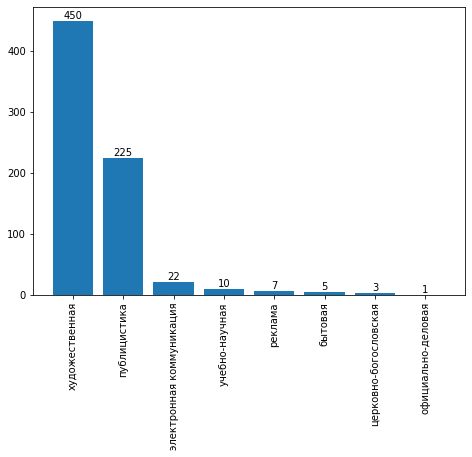

In [43]:
x_values, y_values = [], []
for item in sentences.aggregate([
    {'$group': {'_id': {'status': '$sphere'}, 'count': {'$sum': 1}}},
    {'$sort': {'count': -1}},
    {'$limit': 10}]):

    x_values.append(item['_id']['status'])
    y_values.append(item['count'])

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bars = ax.bar(x_values, y_values)
ax.bar_label(bars)
plt.xticks(rotation=90)
plt.show()

### Полнотекстовый поиск
✔ работа с текстом

Это похоже на то, что было на паре, но поиск более продвинутый и user-friendly.

In [44]:
def search_word(word, n_sents, by_lemma=False, by_token=True,
                pos=None, animacy=None, aspect=None, case=None,
                degree=None, foreign=None, gender=None, mood=None,
                number=None, person=None, polarity=None, tense=None,
                variant=None, verbform=None, voice=None):

    seen_in = []

    # поиск предложений, где есть данная лемма
    if by_lemma:
        # словарь параметров для поиска
        to_search = {'lemma': word}
        if pos is not None:
            to_search['pos'] = pos
        # проверка, что такая(ие) лемма(ы) есть
        if lemmas.count_documents(to_search) > 0:
            for lemma in lemmas.find(to_search):
                seen_in.extend(lemma['docs'])
        else:
            print('Извините, лемма не найдена.')
            return

    # поиск предложений, где есть данный токен
    elif by_token:
        features = {'pos': pos, 'animacy': animacy, 'aspect': aspect,
                    'case': case, 'degree': degree, 'foreign': foreign,
                    'gender': gender, 'mood': mood, 'number': number,
                    'person': person, 'polarity': polarity, 'tense': tense,
                    'variant': variant, 'verbform': verbform, 'voice': voice,
                    'text': word}
        to_search = {k: v for k, v in features.items() if v is not None}
        if tokens.count_documents(to_search) > 0:
            for token in tokens.find(to_search):
                seen_in.extend(token['docs'])
        else:
            print('Извините, словоформа не найдена.')
            return

    # выводим нужное число результатов
    seen_in = list(set(seen_in))
    for doc in sentences.find({'_id': {'$in': seen_in}}).limit(n_sents):
        print(doc)

In [66]:
search_word('приехать', 5, by_token=True)

{'_id': ObjectId('62458b86fa28fb86d8292f75'), 'author': 'коллективный', 'header': 'Форум: комментарии к фильму «Все будет хорошо»', 'sphere': 'электронная коммуникация', 'ttype': 'комментарии', 'topic': ['досуг, зрелища и развлечения', 'искусство и культура'], 'medium': 'электронный текст', 'text': '[awesom13]  Каждая семья здесь имеет свою историю, от которых сердце кровью обливается: Одинокий парализованный дедушка, потерявший любимую жену полтора десятилетия назад и вспоминающий о своей спортивной молодости; Бывший десантник, любящий своих жену и сына, но находящийся не в состоянии окружить их заботой и любовью из-за пристрастия к спиртному; Музыкант, которого и мужем - то стесняется назвать женщина, горюющая из-за беспросветно прожитых «лучших» годах жизни; Молодая пара, мечтающая о детях и счастливой жизни, но видящая своё будущее лишь в работе на заводе ради собственного жилья; девушка, ждущая обещавшего приехать за ней прославившегося музыканта на белом «мерседесе»… Подобно взры

### Подсчет частотности приставок
#### Шаг 1: для каждой приставки найти леммы, в состав которых она входит, и сохранить эту информацию

In [46]:
for prefix in prefixes.find({}):
    prefix_name = prefix['prefix_name']
    prefix_id = prefix['_id']
    regexp = '^{}'.format(prefix_name)
    found_in = [lemma['_id'] for lemma in lemmas.find({'lemma': {'$regex': regexp},
                                                       'pos': 'VERB'})]
    prefixes.find_one_and_update({'_id': prefix_id}, {'$set': {'found_in': found_in}})

In [47]:
prefixes.find_one({'prefix_name': 'на'})

{'_id': ObjectId('62458b81fa28fb86d8292edd'),
 'prefix_name': 'на',
 'senses': ['направленности действия на что-н., напр. накинуть, -накатить, налететь, набросить;',
  'полноты действия и большого количества его объектов, напр. наговорить, накупить, народить, напрясть, накомкать, накидать;',
  'проявления действия в незначительной степени, слабо, неинтенсивно, напр. напевать, наигрывать, насвистывать, накрапывать;',
  'с постфиксом "ся" - полной завершенности действия, удовлетворенности им, напр. наесться, навоеваться, нашалиться;',
  'тщательности или интенсивности действия, напр. начистить (пуговицы), нагладить (рубашку), наговаривать, названивать;',
  'приучения к действию, напр. натренировать, наездить (лошадь), намуштровать;',
  'собственно предела действия, напр. написать, нарисовать, начертить, намочить, насмешить, напугать.'],
 'found_in': [ObjectId('62458bf6fa28fb86d8294d3c'),
  ObjectId('62458bf3fa28fb86d8294c79'),
  ObjectId('62458baefa28fb86d8293d9e'),
  ObjectId('62458be7f

### Шаг 2: сложная конструкция с обращением к двум коллекциям
✔ unwind, lookup, group, push

In [48]:
for p in prefixes.aggregate([{'$unwind': '$found_in'},  # смотрим на поле "леммы с приставкой"
                             # находим леммы в соответствующей коллекции
                             {'$lookup': {'from': 'lemmas', 'localField': 'found_in',
                                          'foreignField': '_id', 'as': 'lemmas_data'}},
                             # собираем в массив
                             {'$unwind': '$lemmas_data'},
                             # группируем по id, сохраняем информацию
                             {'$group': {'_id': '$_id',
                                         'lemmas_data': {'$push': '$lemmas_data'}}},
                             # выводим один результат
                             # {'$limit': 1}
                            ]):
    prefix_freq = 0
    for lemma in p['lemmas_data']:
        prefix_freq += lemma['freq']
    print(prefixes.find_one({'_id': p['_id']})['prefix_name'] +\
          ': {} вхождений'.format(prefix_freq))

при: 828 вхождений
на: 68 вхождений
с: 287 вхождений
